In [2]:
# Import needed libs
using CSV
using Optim
using Statistics
using Plots

In [3]:
# Read data
X_train = convert(Matrix, CSV.read("X_train.csv"));
X_test = convert(Matrix, CSV.read("X_test.csv")); 
y_train = CSV.read("y_train.csv")[:, 1];
y_test = CSV.read("y_test.csv")[:, 1];

In [4]:
# Normalise the training design matrix
function scale_features(X)
    μ = mean(X, dims=1)
    σ = std(X, dims=1)

    X_norm = (X .- μ) ./ σ

    return (X_norm, μ, σ);
end


# Normalise the testing design matrix
function transform_features(X, μ, σ)
    X_norm = (X .- μ) ./ σ
    return X_norm;
end


# Scale training features and get artificats for future use
X_train_scaled, μ, σ = scale_features(X_train);

# Transform the testing features by using the learned artifacts
X_test_scaled = transform_features(X_test, μ, σ);

In [6]:
function sigmoid(z)
    return 1 ./ (1 .+ exp.(.-z))
end

sigmoid (generic function with 1 method)

In [9]:
function regularised_cost(X, y, θ, λ)
    m = length(y)

    # Sigmoid predictions at current batch
    h = sigmoid(X * θ)

    # left side of the cost function
    positive_class_cost = ((-y)' * log.(h))

    # right side of the cost function
    negative_class_cost = ((1 .- y)' * log.(1 .- h))

    # lambda effect
    lambda_regularization = (λ/(2*m) * sum(θ[2 : end] .^ 2))

    # Current batch cost. Basically mean of the batch cost plus regularization penalty
    𝐉 = (1/m) * (positive_class_cost - negative_class_cost) + lambda_regularization

    # Gradients for all the theta members with regularization except the constant
    ∇𝐉 = (1/m) * (X') * (h-y) + ((1/m) * (λ * θ))  # Penalise all members

    ∇𝐉[1] = (1/m) * (X[:, 1])' * (h-y) # Exclude the constant

    return (𝐉, ∇𝐉)
end

regularised_cost (generic function with 1 method)

In [12]:
function logistic_regression_sgd(X, y, λ, fit_intercept=true, η=0.01, max_iter=1000)
    
    # Initialize some useful values
    m = length(y); # number of training examples

    if fit_intercept
        # Add a constant of 1s if fit_intercept is specified
        constant = ones(m, 1)
        X = hcat(constant, X)
    else
        X # Assume user added constants
    end

    # Use the number of features to initialise the theta θ vector
    n = size(X)[2]
    θ = zeros(n)

    # Initialise the cost vector based on the number of iterations
    𝐉 = zeros(max_iter)

    for iter in range(1, stop=max_iter)

        # Calcaluate the cost and gradient (∇𝐉) for each iter
        𝐉[iter], ∇𝐉 = regularised_cost(X, y, θ, λ)

        # Update θ using gradients (∇𝐉) for direction and (η) for the magnitude of steps in that direction
        θ = θ - (η * ∇𝐉)
    end

    return (θ, 𝐉)
end

logistic_regression_sgd

In [13]:
θ, 𝐉 = logistic_regression_sgd(X_train_scaled, y_train, 0.0001, true, 0.3, 3000);

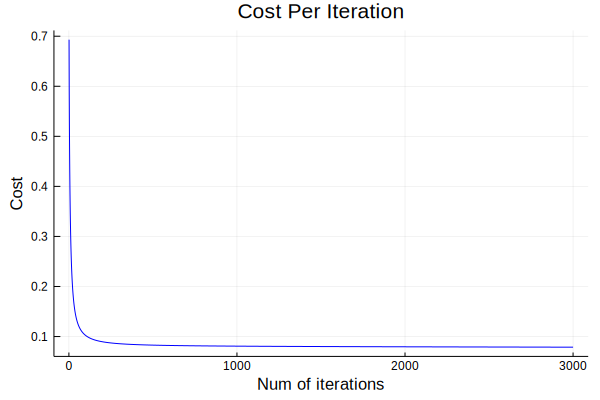

In [14]:
plot(𝐉, color="blue", title="Cost Per Iteration", legend=false,
     xlabel="Num of iterations", ylabel="Cost")

In [15]:
function predict_proba(X, θ, fit_intercept=true)
    m = size(X)[1]

    if fit_intercept
        # Add a constant of 1s if fit_intercept is specified
        constant = ones(m, 1)
        X = hcat(constant, X)
    else
        X
    end

    h = sigmoid(X * θ)
    return h
end

predict_proba

In [17]:
function predict_class(proba, threshold=0.5)
    return proba .>= threshold
end

predict_class

In [18]:
train_score = mean(y_train .== predict_class(predict_proba(X_train_scaled, θ)));

In [22]:
println("Training score: ", round(train_score, sigdigits=4))

Training score: 0.9769


In [20]:
test_score = mean(y_test .== predict_class(predict_proba(X_test_scaled, θ)));

In [21]:
println("Testing score: ", round(test_score, sigdigits=4))

Testing score: 0.9788
